# Electricity Price Forecasting using Deep Neural Networks (DNN)

## Introduction

The National Electricity Market (NEM) in Australia is a wholesale electricity market that spans five interconnected regions: New South Wales (including the Australian Capital Territory), Queensland, Victoria, South Australia, and Tasmania. In the NEM, supply and demand are matched in real-time through a process known as dispatch and settlement. This process is managed by the Australian Energy Market Operator (AEMO) and operates at five-minute intervals to ensure efficient market operation, optimal resource utilization, and the stability and reliability of the electricity grid.

Due to the complexity of the electricity market, forecasting prices is a challenging task. However, one of the projects I am currently working on requires forecasting prices for each region. I see this as a great opportunity to apply deep learning techniques in my final project.


## 1. Objective


Forecasting electricity prices using DNN aims to develop region-specific models that can capture complex, nonlinear relationships between market drivers (e.g., demand, time features, and generator characteristics) and electricity spot prices. The objective is to improve forecasting accuracy for each region in the NEM using deep neural network architectures and assess performance against standard metrics.

---

## 2. Data Overview and Processing

### **Data Sources**  
The historical electricity data was collected from the AEMO website, covering one year from **April 1, 2024, to March 31, 2025**. It includes:

- Regional demand and prices  
- Generator dispatch and capacity data by DUID  
- Generator metadata, including fuel type and region  

The data is originally recorded at 5-minute intervals and has been aggregated to hourly intervals for convenience. Hourly resolution is considered sufficient to capture price spikes.

The dataset is stored in CSV format and has been uploaded to Kaggle for easy access and use in further analysis or projects.  
🔗 **[Download the dataset from Kaggle](https://www.kaggle.com/datasets/baohoangnguyen/nem-hourly-dispatch)**

---


### **Data Processing**

The original dataset contained approximately 3.5 million observations. It was then cleaned and aggregated by fuel type. The final dataset used for modeling consists of **276,201 observations** with the following variables:

**Dependent Variable (Target):**  
Electricity prices for each region

**Independent Variables (Features):**  
- `Demand`: Electricity demand for each region
- `Hour`: Hour of day (0–23)  
- `DayofWeek`: Day of the week (0 = Monday to 6 = Sunday)  
- `Month`: Month of the year (1–12)  
- `IsWeekend`: Weekday (0-4) and weekend (5-6) 
- `FuelType`: Fuel type (coal, gas, hydro, wind, solar, battery etc.)  


In [1]:
# Import library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


############################################ Data Processing ##############################################

# Load data
df = pd.read_csv("C:/Users/hnguyen/Master of Science in Data Science - CU Boulder/Introduction to Deep Learning/Final project/Data.csv",index_col=False)

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Clean data set
# Drop NA values
df = df.dropna()

# Convert to float type
df['Capacity'] = df['Capacity'].replace({',': ''}, regex=True).astype(float)
df['Dispatch'] = df['Dispatch'].replace({',': ''}, regex=True).astype(float)
df['Demand'] = df['Demand'].replace({',': ''}, regex=True).astype(float)

# Remove Biomass fuel type due to tiny scale
df = df[~df['FuelType'].isin(['Biomass'])]

# Group by fuel type
df = df.drop(columns=['DUID'])
df = df.groupby(['Date', 'FuelType','Region']).agg({
    'Dispatch': 'sum',
    'Capacity': 'sum',
    'Price': 'first', 
    'Demand': 'first'}).reset_index()

# Create time variables
df['Date'] = pd.to_datetime(df['Date'])
df['Hour'] = df['Date'].dt.hour
df['DayofWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['IsWeekend'] = df['DayofWeek'].isin([5, 6]).astype(int)

# Explore data
df.info()
df.describe()
df

C:\Users\hnguyen\AppData\Local\Temp\ipykernel_50884\2766129576.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("C:/Users/hnguyen/OneDrive - ACIL ALLEN PTY LTD/Desktop/Helen Nguyen/Resources/Master of Science in Data Science - CU Boulder/Introduction to Deep Learning/Final project/Data.csv",index_col=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276201 entries, 0 to 276200
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       276201 non-null  datetime64[ns]
 1   FuelType   276201 non-null  object        
 2   Region     276201 non-null  object        
 3   Dispatch   276201 non-null  float64       
 4   Capacity   276201 non-null  float64       
 5   Price      276201 non-null  float64       
 6   Demand     276201 non-null  float64       
 7   Hour       276201 non-null  int64         
 8   DayofWeek  276201 non-null  int64         
 9   Month      276201 non-null  int64         
 10  IsWeekend  276201 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(1), int64(3), object(2)
memory usage: 22.1+ MB


,Date,FuelType,Region,Dispatch,Capacity,Price,Demand,Hour,DayofWeek,Month,IsWeekend
0,2024-04-01,Battery,QLD1,0.000000,2.00,54.678226,5763.012727,0,0,4,0
1,2024-04-01,Black coal,NSW1,5642.017096,8305.00,53.651115,6442.665455,0,0,4,0
2,2024-04-01,Black coal,QLD1,4914.817451,8130.00,54.678226,5763.012727,0,0,4,0
3,2024-04-01,Brown coal,VIC1,4094.037070,4820.00,48.828977,3784.116364,0,0,4,0
4,2024-04-01,Hydro,NSW1,83.099632,1957.00,53.651115,6442.665455,0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...
276196,2025-04-01,Wind,NSW1,1248.616353,2477.69,57.010000,6951.660000,0,1,4,0
276197,2025-04-01,Wind,QLD1,447.097580,1945.97,62.410440,6372.380000,0,1,4,0
276198,2025-04-01,Wind,SA1,1151.448270,2410.14,23.689680,1410.230000,0,1,4,0
276199,2025-04-01,Wind,TAS1,76.795559,434.10,47.120000,997.730000,0,1,4,0



### **Data Visualisation**

#### **Visualise price by region**

There are five regions in the NEM (NSW1, QLD1, SA1, TAS1, and VIC1), each with different market characteristics and subject to interconnector constraints. Therefore, the data will be split by region for model training in order to identify the most important features specific to each area. 

Below is a boxplot of prices in each region, with the 95th percentile values highlighted. It can be seen that the 95th percentile values are around $250 across regions.

#### **Visualise price by time**

The charts below illustrate how electricity prices fluctuate based on the time of day, day of the week, and month. These temporal patterns can reveal important insights into demand cycles, operational constraints, and market behaviors within the NEM.

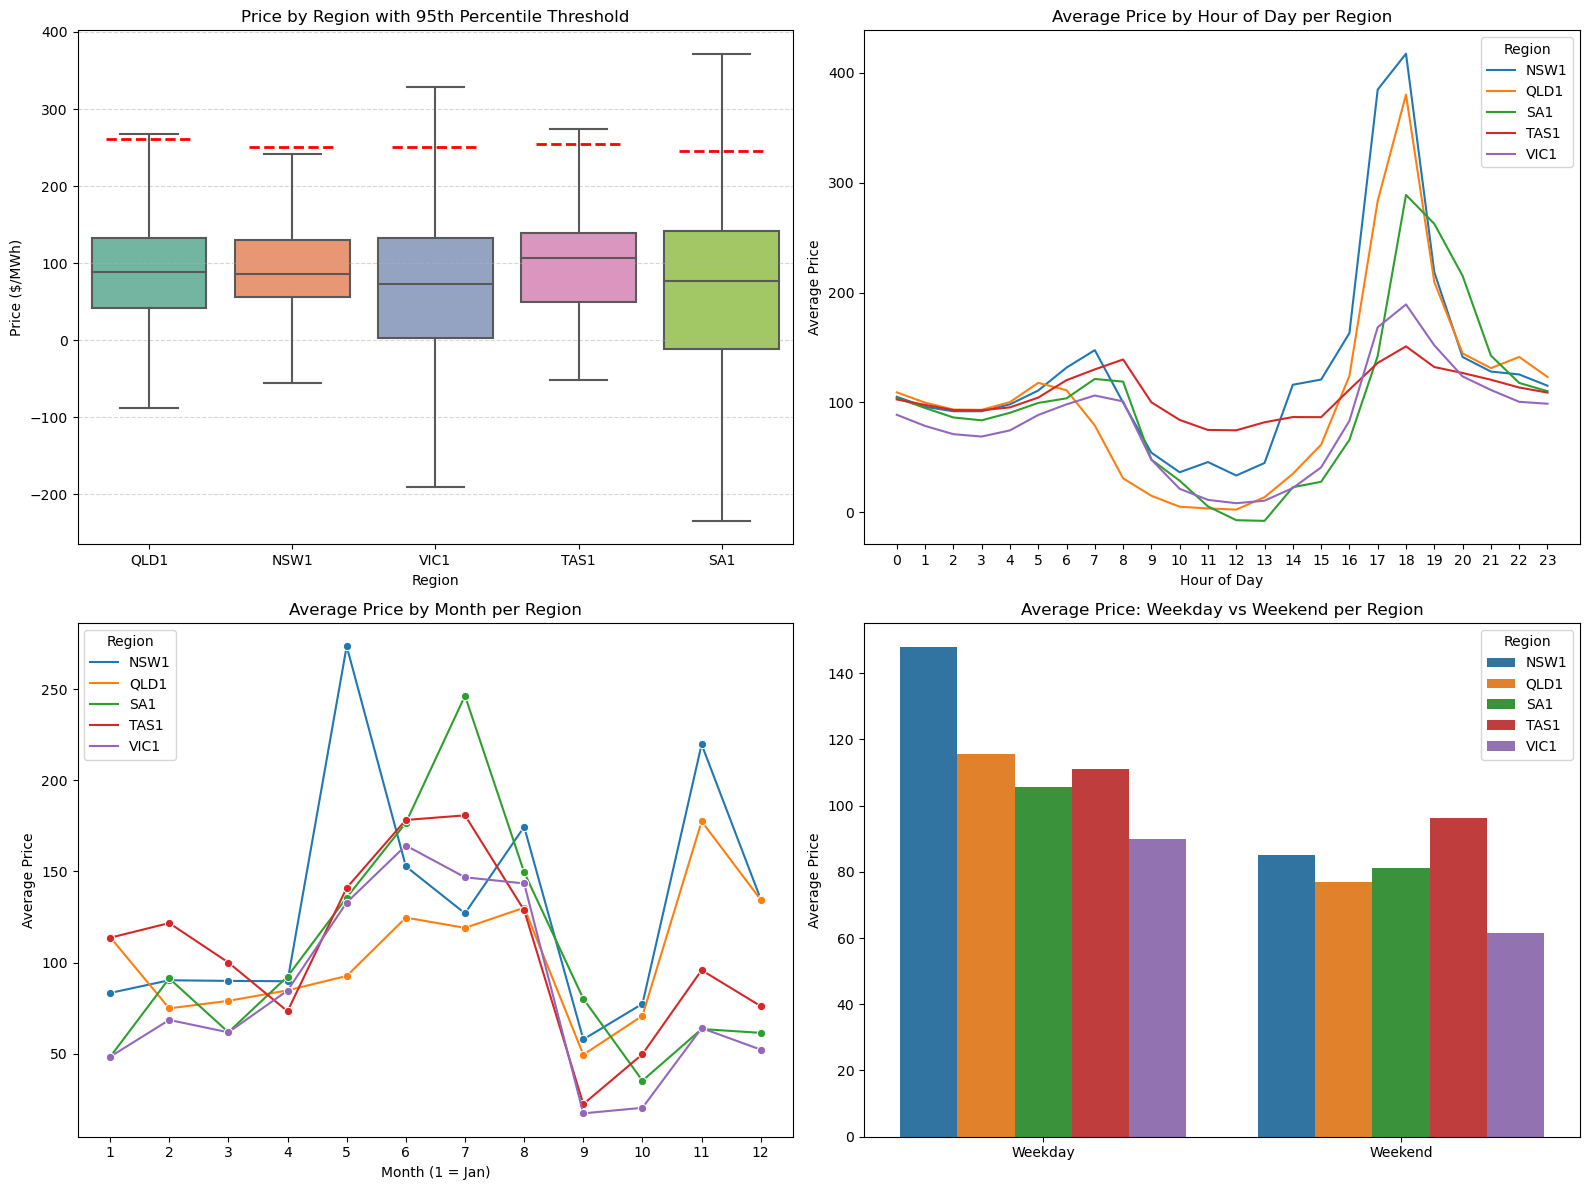

In [2]:
########################################## Explore data and visualization ############################################

# Prepare aggregates
df.columns = df.columns.str.strip()
df_plot = df.copy()
hourly_avg = df.groupby(['Hour', 'Region'])['Price'].mean().reset_index()
month_avg = df.groupby(['Month', 'Region'])['Price'].mean().reset_index()
weekend_avg = df.groupby(['IsWeekend', 'Region'])['Price'].mean().reset_index()
weekend_avg['DayType'] = weekend_avg['IsWeekend'].map({0: 'Weekday', 1: 'Weekend'})

# Calculate 95th percentile by region for overlay
percentile_95 = df_plot.groupby('Region')['Price'].quantile(0.95).reset_index()
percentile_95.columns = ['Region', 'P95']

# --- Create 2x2 Grid of Charts ---
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# --- 1. Custom Boxplot with 95th Percentile ---
sns.boxplot(data=df_plot, x='Region', y='Price', ax=axs[0, 0], showfliers=False, palette='Set2')
axs[0, 0].set_title('Price by Region with 95th Percentile Threshold')
axs[0, 0].set_xlabel('Region')
axs[0, 0].set_ylabel('Price ($/MWh)')
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.5)

# Overlay red dashed lines for 95th percentile
for i, region in enumerate(percentile_95['Region']):
    p95_value = percentile_95.loc[percentile_95['Region'] == region, 'P95'].values[0]
    axs[0, 0].plot([i - 0.3, i + 0.3], [p95_value, p95_value], color='red', linestyle='--', linewidth=2)

# --- 2. Lineplot: Price by Hour ---
sns.lineplot(data=hourly_avg, x='Hour', y='Price', hue='Region', ax=axs[0, 1])
axs[0, 1].set_title('Average Price by Hour of Day per Region')
axs[0, 1].set_xlabel('Hour of Day')
axs[0, 1].set_ylabel('Average Price')
axs[0, 1].set_xticks(range(0, 24))

# --- 3. Lineplot: Price by Month ---
sns.lineplot(data=month_avg, x='Month', y='Price', hue='Region', marker='o', ax=axs[1, 0])
axs[1, 0].set_title('Average Price by Month per Region')
axs[1, 0].set_xlabel('Month (1 = Jan)')
axs[1, 0].set_ylabel('Average Price')
axs[1, 0].set_xticks(range(1, 13))

# --- 4. Barplot: Weekday vs Weekend ---
sns.barplot(data=weekend_avg, x='DayType', y='Price', hue='Region', ax=axs[1, 1])
axs[1, 1].set_title('Average Price: Weekday vs Weekend per Region')
axs[1, 1].set_xlabel('')
axs[1, 1].set_ylabel('Average Price')

# Show the full grid
plt.tight_layout()
plt.show()

## 3. Methodology

This study utilizes deep learning techniques, specifically Deep Neural Networks (DNN), to forecast electricity prices for each region within the National Electricity Market (NEM). By leveraging the ability of DNNs to capture complex nonlinear relationships and temporal patterns in large datasets, the model aims to improve the accuracy of price predictions compared to traditional statistical methods.

### Price Filtering
To reduce the impact of extreme price spikes and outliers, the modeling process includes only price observations below $300/MWh. Prices above this threshold are considered outliers that could disproportionately influence the model training and degrade predictive performance. Filtering out these values helps the model focus on capturing typical market behavior more reliably.

### Data Splitting

To ensure the robustness of model training and evaluation, the dataset is split into training and testing sets:
- **80% for training**: Used to fit the models and perform hyperparameter tuning.
- **20% for testing**: Held out for evaluating the model's generalization ability on unseen data.

The split is done randomly but with a fixed seed to ensure reproducibility.

### DNN model

For each region, a separate deep neural network model is trained. The architecture used for this project includes:

- Input layer matching the number of selected features

- Three hidden layers with 256, 128, and 64 neurons respectively

- ReLU activation functions to capture non-linear relationships

- Dropout layers to prevent overfitting

- Output layer with a single neuron to predict spot price

The model uses:

- Loss function: Mean Squared Error (MSE)

- Optimizer: Adam

- Callback: Early stopping with patience of 5 epochs based on validation loss

The models are trained for a maximum of 10 epochs with a batch size of 64 and an internal validation split of 20%.

### Model Evaluation

The model performance for each region is evaluated using:

- Mean Absolute Error (MAE): Measures average magnitude of prediction errors

- Root Mean Squared Error (RMSE): Penalizes large errors more than MAE

- R² Score: Measures the proportion of variance explained by the model

These metrics provide a comprehensive view of model accuracy and generalization.



Training model for region: SA1
1522/1522 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
MAE: 35.66
RMSE: 46.06
R² Score: 0.71


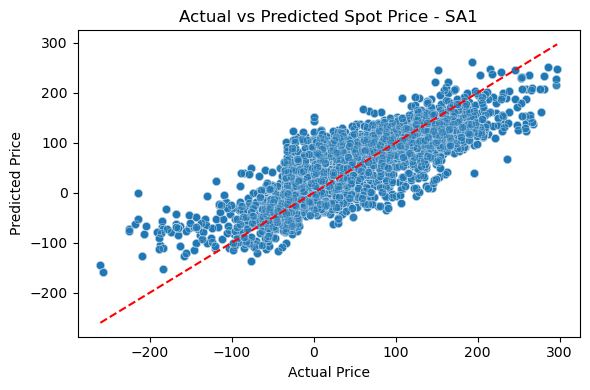


Training model for region: VIC1
3649/3649 ━━━━━━━━━━━━━━━━━━━━ 3s 910us/step
MAE: 23.35
RMSE: 31.34
R² Score: 0.84


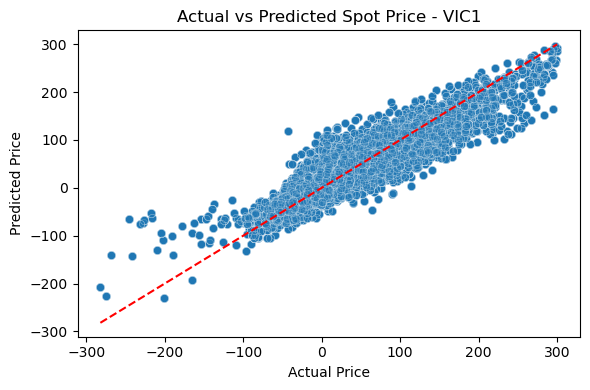


Training model for region: QLD1
5308/5308 ━━━━━━━━━━━━━━━━━━━━ 5s 898us/step
MAE: 20.81
RMSE: 28.92
R² Score: 0.86


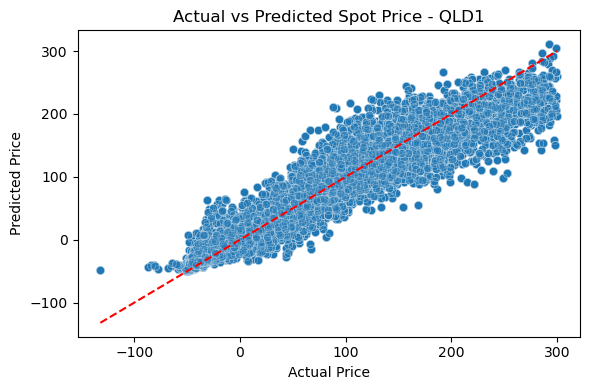


Training model for region: NSW1
3979/3979 ━━━━━━━━━━━━━━━━━━━━ 4s 930us/step
MAE: 21.21
RMSE: 28.96
R² Score: 0.82


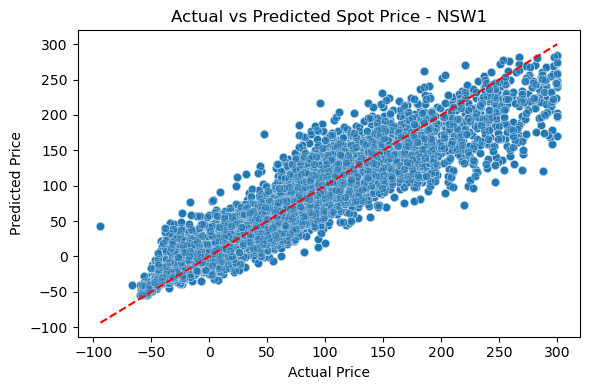


Training model for region: TAS1
1790/1790 ━━━━━━━━━━━━━━━━━━━━ 2s 901us/step
MAE: 37.48
RMSE: 49.28
R² Score: 0.53


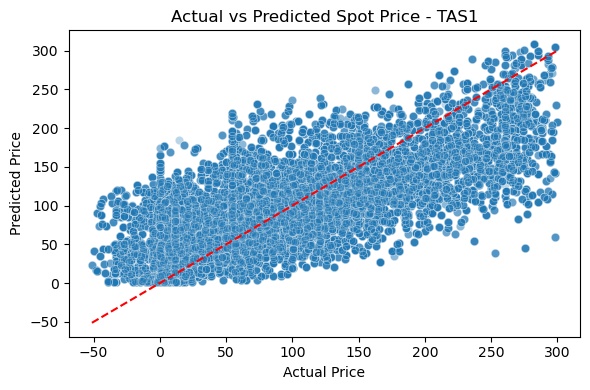

In [3]:
################################### Training model and valuation on test set ################################################

df1 = df.copy()
regions = df1['Region'].unique()

# -------------------- Train model per region --------------------
for region in regions:
    print(f"\n{'='*30}\nTraining model for region: {region}\n{'='*30}")
    
    df_region = df1[df1['Region'] == region].copy()

    # Filter for Price < 300
    df_region = df_region[df_region['Price'] < 300]

    # Pivot capacity by FuelType
    cap_pivot = df_region.pivot_table(index='Date', columns='FuelType', values='Capacity', aggfunc='sum').add_prefix('Capacity_')
    df_region = df_region.merge(cap_pivot, on='Date', how='left')

    # Features and target
    features = ['Demand', 'Hour', 'DayofWeek', 'Month', 'IsWeekend'] + \
               [col for col in df_region.columns if col.startswith('Capacity_')]
    
    df_model = df_region[['Price'] + features].dropna()
    X = df_model[features]
    y = df_model['Price']

    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # -------------------- Improved DNN --------------------
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=10,
                        batch_size=64,
                        callbacks=[es],
                        verbose=0)

    # -------------------- Evaluation --------------------
    y_pred = model.predict(X_test).flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")

    # -------------------- Plot --------------------
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"Actual vs Predicted Spot Price - {region}")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.tight_layout()
    plt.show()


## 4. Interpretation and Findings

- The model performs well for NSW1, QLD1, SA1 and VIC1, achieving R² scores between 0.71 - 0.86, indicating strong predictive performance.

- However, TAS1 showed a significantly lower R² score (0.53). This is likely due to Tasmania’s unique market characteristics:

    - TAS1 is connected to the NEM through a single interconnector (Basslink) and frequently imports/export electricity based on VIC1 market prices.

    - The region is heavily reliant on hydropower, whose operational constraints (e.g., water storage levels, rainfall) are not included in the model.

    - Price signals in TAS1 often originate externally, and the model lacks VIC1 prices or interconnector flow data as input features.

- The MAE and RMSE values are also lower for the higher-performing regions, indicating better fit.

- Visual inspection of actual vs. predicted scatter plots shows clustering around the diagonal line, especially in regions with higher R² values.

- The use of capacity by fuel type as features added useful context to the model, helping capture the supply mix and its influence on pricing.

---

## Conclusion

This project demonstrates the effectiveness of deep neural networks in forecasting electricity prices in the Australian NEM. The DNN models can capture complex interactions among demand, supply, and time-based features. Region-specific models improve performance by accounting for local characteristics.

Key takeaways:

- DNNs are capable of achieving high accuracy, especially in large and more stable markets like QLD and VIC.

- Temporal and capacity-related features significantly contribute to model performance.

- Forecasting performance may be further improved by incorporating:

    - Weather data,

    - Interconnector flows,

    - Market bidding behavior,

    - Or additional engineered features, especially for TAS.

This modeling framework can be extended for real-time price forecasting, bidding strategy support, and policy analysis in future work.